# Workshop 2: Neural networks - structure, building, and training

Jake Brusca

# Setup

Information on setting up a Python environment and package management
can be found in the [first
workshop.](https://cnrrobertson.github.io/other/mlseminar/fall_2022/workshop1_intro/workshop1_intro.html)

In Terminal:

    mamba activate workshop 
    mamba install numpy py-pde tensorflow matplotlib

You can use [Google colab](https://colab.research.google.com) if unable
to run local Jupyter Notebooks.

In cell:

    !pip install numpy py-pde tensorflow matplotlib

In [1]:
#Import packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

# Learning a simple model

As a quick example, we’ll try to fit a wide, shallow neural network to
$sin(x)$ on $[0, 4\pi]$. We pick a network with a single layer, using
ReLU as the activation function. We create a set of sample data
$\overline{X},\overline{Y}$, then try to fit the network
$N(x_i,\beta) \approx y_i$ $$
\beta^* = \text{argmin} \sum (N(x_i;\beta)-y_i)^2
$$ From the universal approximation theorem, we know that some network
exists which can approximate this curve to any precision, however it’s
unclear that the network we discover from our optimization problem will
be that network.

 1/13 [=>............................] - ETA: 0s13/13 [==============================] - 0s 492us/step

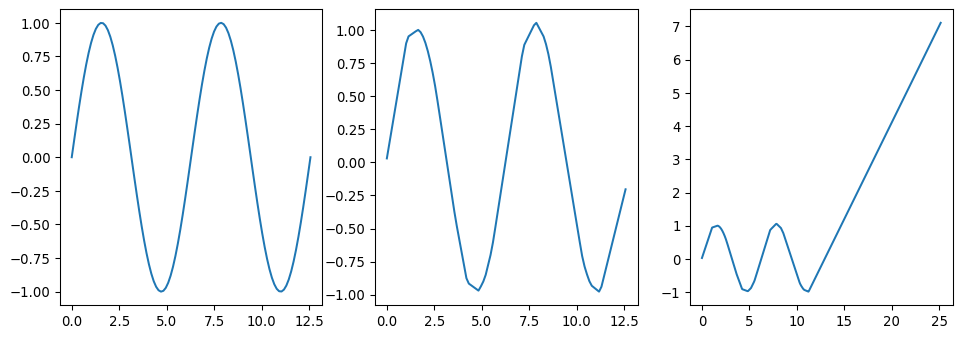

In [2]:
# Generate sin data
xmin_s = 0
xmax_s= 4*np.pi
nx_s = 100
x_s= np.linspace(xmin_s,xmax_s,nx_s)
y_s= np.sin(x_s)

# Build a model
model_s = Sequential()
model_s.add(Dense(700, input_shape=(1,), activation='relu'))
model_s.add(Dense(1))
model_s.compile(loss = 'mae',optimizer = 'adam')
model_s.fit(x_s,y_s,epochs=10000,batch_size = 25, verbose = 0)

# Make Prediction
y_pred_s = model_s.predict(x_s) # Prediction with training data
x_test_s = np.linspace(xmin_s,2*xmax_s,4*nx_s)
y_test_s = model_s.predict(x_test_s)

# Plot Results
plt.figure(figsize = (12,4))
plt.plot(x_test_s,y_test_s)
plt.subplot(1,3,1)
plt.plot(x_s,y_s)
plt.subplot(1,3,2)
plt.plot(x_s,y_pred_s)
plt.subplot(1,3,3)
plt.plot(x_test_s,y_test_s)

# Learning a PDE

We consider a simple 1D transport equation with periodic boundary
conditions

The true solution to this PDE is given by
$u(x,t) = u_0(\text{mod}(x-t,1))$, which can be found using the method
of characteristics on the free domain and then truncating to a periodic
domain. Though we have access to the true solution, we will generate our
training data using a prepackaged numerical PDE solver `py-pde`. We will
use a Gaussian as our initial data $u_0(x) = e^{-100(x-.3)^2}$ and solve
on the domain $[0,1]$.

Note that this isn’t an attempt to solve the PDE using NNs, rather we
are just using the PDE data as a specific set of training data.

In [3]:
import pde

# Domain
xmin = 0.0
xmax = 1.0
nx = 101
tmin = 0.0
tmax = 1.0
dt = 1e-6
save_dt = 0.01
init_cond = "1*exp(-(1/.01)*(x-0.3)**2)"

# Initialize objects
grid = pde.CartesianGrid([(xmin,xmax)],nx,periodic=True)
h = pde.ScalarField.from_expression(grid,init_cond,label="h(x,t)")
eq = pde.PDE({"h": "-d_dx(h)"})
storage = pde.MemoryStorage()

# Run
result = eq.solve(h,t_range=tmax,dt=dt,tracker=storage.tracker(save_dt))

# Save data
data = np.array(storage.data)
np.save("simple_wave.npy", data)

# Data Processing

Arguably the most important part of training a machine learning
algorithm is the data. Most prepackaged algorithms expect data to be
formatted in a specific way, usually as an array where each column
represents different features and each row represents the samples. As it
stands, we have our target $h(x,t)$ data represented as a matrix, and
have our $x,t$ each represented as single arrays. We need create an
array of each pair of $x,t$ data points, and map the $h(x,t)$ to array
of the corresponding values.

In [4]:
# Create training data
x = np.linspace(xmin,xmax,nx)
nt = int((tmax-tmin)/save_dt+1)
t = np.linspace(tmin,tmax,nt)
T = np.repeat(t,nx)
X = np.tile(x,int(nt))
XT = np.transpose(np.array([X,T]))
y = np.transpose(data.reshape(nt*nx))

# Building a Network

We’ll use the Keras package to build our Neural Networks. Keras is an
API for building Neural Networks built on `tensorflow`. We can
initialize the network using the Sequential() class, then add layers
.add() method for our model. We will use Dense layers, which means that
each node takes inputs from all of the other nodes in the previous
layer. We can specify the initial input shape in the first layer, and
each size and activation function for each layer.

  1/319 [..............................] - ETA: 8s128/319 [===========>..................] - ETA: 0s282/319 [=========================>....] - ETA: 0s319/319 [==============================] - 0s 354us/step

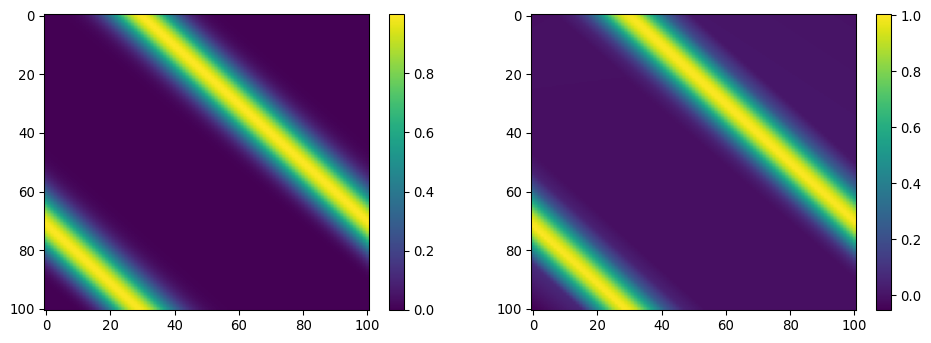

In [5]:
# Build model
model = Sequential()
model.add(Dense(12, input_shape=(2,), activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# Train model
model.fit(XT,y,epochs=1000, batch_size=200, verbose = 0)
yPred = np.array(model.predict(XT)).reshape(nt,nx)
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
p = plt.imshow(data,aspect = 'auto')
plt.colorbar()

plt.subplot(1,2,2)
p = plt.imshow(yPred,aspect = 'auto')
plt.colorbar()

  1/319 [..............................] - ETA: 3s145/319 [============>.................] - ETA: 0s289/319 [==========================>...] - ETA: 0s319/319 [==============================] - 0s 350us/step

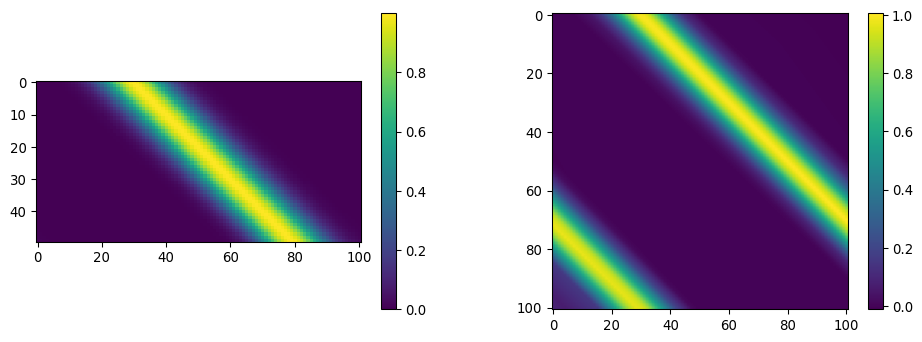

In [6]:
# Create subset of training data
t_stop= .5/tmax
t_split = nx*int(t_stop*nt)
XT_Train = XT[0:t_split,:]
y_Train = y[0:t_split]

# Fit new model
model.fit(XT_Train,y_Train,epochs=1000, batch_size=200, verbose = 0)

plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
p = plt.imshow(y_Train.reshape(int(t_stop*nt),nx))
plt.colorbar()

plt.subplot(1,2,2)
yPred = np.array(model.predict(XT)).reshape(nx,nt)
p = plt.imshow(yPred)
plt.colorbar()

# Hyper Parameters

One of the many challenges you face when working with Neural Networks is
the wide range of hyper-parameters you need to choose in order to build
the network. Some of the more obvious ones are the number of layers, the
depth of each layer, and the activation function you use. It’s clear
that these can have dramatic effects on the resulting neural network,
but even smaller changes can too. In this example, we double the number
of epochs that the network is trained on. This tends to result in a
lower quality prediction, likely from overfitting to specific training
data. There are ways to better chose hyper-parameters and mitigate
things like over fitting, but that is beyond the scope of this workshop.

  1/319 [..............................] - ETA: 3s141/319 [============>.................] - ETA: 0s280/319 [=========================>....] - ETA: 0s319/319 [==============================] - 0s 362us/step

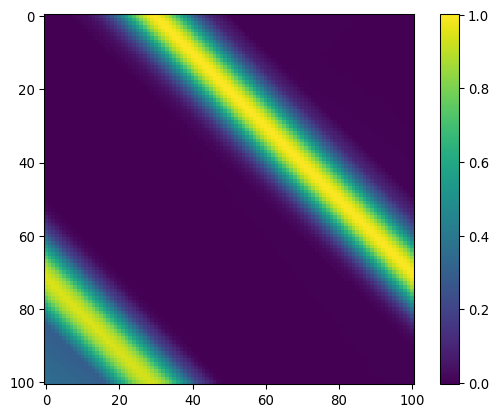

In [7]:
model.fit(XT_Train,y_Train,epochs=2000, batch_size=200, verbose = 0)
yPred = np.array(model.predict(XT)).reshape(nx,nt)
p = plt.imshow(yPred)
plt.colorbar()